# Import the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
from moviepy.editor import *
from IPython.display import HTML
import os

# Class Definition

The following class (CLaneDetection) provides the helper functions required to implement the 8 stage pipeline for lane detection. The ctor of the class initializes the parameters which can be tuned to optimize the performance of the pipeline.
Finally, it provides a public interface function process_image(), which executes the entire pipeline.
The functions of this class support debug level logging as well, which can be activated by setting the flag debug_logging to TRUE.

In [2]:
class CLaneDetection:
    """
    This class provides data and associated methods to detect 
    lanes on a road.
    """
    
    # Static class variables to define the region of interest 
    # in terms of a quadrilateral
    # Quad base and top length are in pixels while height is 
    # in terms of percentage of the y size of the image.
    quad_height = 0.61
    quad_base_len = 950
    quad_top_len = 140
    
    def __init__(self, gaussian_kernel_size = 3, canny_lower_treshold = 50, 
                 canny_upper_treshold = 150, hough_rho = 1, hough_theta = np.pi/180,
                 hough_threshold = 5, hough_min_line_length = 10, 
                 hough_max_line_gap = 15, debug_logging = False):
        
        """ 
        The constructor of this class initializes the tunable 
        parameters used in lane detection algorithm.
        """
        
        self.__shape = []
        self.__gaussian_kernel_size = gaussian_kernel_size
        self.__canny_lower_treshold = canny_lower_treshold
        self.__canny_upper_treshold = canny_upper_treshold
        self.__hough_rho = hough_rho
        self.__hough_theta = hough_theta
        self.__hough_threshold = hough_threshold
        self.__hough_min_line_length = hough_min_line_length
        self.__hough_max_line_gap = hough_max_line_gap
        self.__debug_logging = debug_logging
        
        if self.__debug_logging:
            print("Ctor of class CLaneDetection invoked !")
        
    def __selectColor(self, image):
        """
        This method forms the stage # 1 of the lane detection pipeline.
        It selects only white and yellow pixels from an image since
        they constitute the lane markings on a road.
        """
        #Select white color
        red_threshold = 200
        green_threshold = 200
        blue_threshold = 200
        rgb_threshold = np.array([red_threshold, green_threshold, blue_threshold])
        upper_threshold = np.array([255, 255, 255])
        mask = cv2.inRange(image, rgb_threshold, upper_threshold)
        white_image = cv2.bitwise_and(image, image, mask=mask)

        #Select yellow color
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv_yellow_threshold = np.array([80,90,90])
        hsv_yellow_upper_threshold = np.array([100,255,255])
        mask = cv2.inRange(hsv, hsv_yellow_threshold, hsv_yellow_upper_threshold)
        yellow_image = cv2.bitwise_and(image, image, mask=mask)

        image = cv2.addWeighted(white_image, 1, yellow_image, 1, 0)
        
        if self.__debug_logging:
            print("Stage-1 : __selectColor method invoked!")
            print("Stage-1 : Color threshold for white == ", rgb_threshold)
            print("Stage-1 : Color threshold for yellow == ", hsv_yellow_threshold)
            print("Stage-1 : Shape of input image == ", image.shape)
            plt.imshow(image)
            plt.title("This is the color selected image - Stage 1")
            plt.show()
        
        return image
    
    def __rgbToGrayScale(self, image):
        """
        This method forms the stage-2 of the lane detection pipeline.
        This function converts the input RGB into a gray sclae image. 
        """
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if self.__debug_logging:
            print("Stage-2 : __rgbToGrayScale (RBG->GRAY scale conversion) method invoked!")
            print("Stage-2 : Shape of input image to __rgbToGrayScale == ", image.shape)
            plt.imshow(image, cmap='Greys_r')
            plt.title("This is the color selected image in gray scale - Stage 2")
            plt.show()
            
        return image
        
    def __maskRegionOfinterest(self, image):
        """
        This method forms the stage-3 of the lane detection pipeline.
        It keeps the region of the image defined by the polygon
        formed from the defines vertices. 
        The rest of the image is set to black.
        """   
        mask = np.zeros_like(image)
        
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(self.__shape) > 2:
            channel_count = self.__shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        ylength = self.__shape[0]
        xlength = self.__shape[1]
        
        quad_height_abs = ylength*CLaneDetection.quad_height
    
        vertices = np.array([[((xlength - CLaneDetection.quad_base_len)/2, ylength),
                              ((xlength - CLaneDetection.quad_top_len)/2, quad_height_abs), 
                              ((xlength + CLaneDetection.quad_top_len)/2, quad_height_abs),
                              ((xlength + CLaneDetection.quad_base_len)/2, ylength)]],
                              dtype=np.int32)
        #filling pixels inside the polygon defined by "vertices" with the fill color 
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_gray_image = cv2.bitwise_and(image, mask)
        
        if self.__debug_logging:  
            print("Stage-3 : __maskRegionOfinterest method invoked !")
            print("Stage-3 : Vertices of the region of interest == ", vertices)
            print("Stage-3 : Shape of the masked image == ", masked_gray_image.shape)
            plt.imshow(masked_gray_image, cmap='Greys_r')
            plt.title("This is the region of interest image - Stage 3")
            plt.show()
    
        return masked_gray_image
    
    def __gaussianFilter(self, image):
        """
        This method forms the stage-4 of the lane detection pipeline.
        It applies a Gaussian Noise kernel. This step is optional
        since the open cv Canny function internally filters 
        the image as well.
        """
        image = cv2.GaussianBlur(image, (self.__gaussian_kernel_size, self.__gaussian_kernel_size), 0)
        
        if self.__debug_logging:
            print("Stage-4 : __gaussianFilter method invoked!")
            print("Stage-4 : Kernel size == ", self.__gaussian_kernel_size)
            plt.imshow(image, cmap='Greys_r')
            plt.title("This is the gaussian filtered image - Stage 4")
            plt.show()
            
        return image
    
    def __cannyEdgeDetection(self, image):
        """
        This method forms the stage-5 of the lane detection pipeline.
        It applies the Canny transform to detect edges in the
        image which is the ouput from stage-4.
        """
        edges = cv2.Canny(image, self.__canny_lower_treshold, self.__canny_upper_treshold)
        if self.__debug_logging:
            print("Stage-5 : __cannyEdgeDetection method invoked!")
            print("Stage-5 : canny lower threshold == ", self.__canny_lower_treshold)
            print("Stage-5 : canny upper threshold == ", self.__canny_upper_treshold)
            plt.imshow(edges, cmap='Greys_r')
            plt.title("This is the canny edge detected image - Stage 5")
            plt.show()
            
        return edges
    
    def __houghTransform(self, edges):
        """
        This method forms the stage-6 of the lane detection pipeline.
        This function applies Hough trasnform to detect lines in the input image.
        The input image should be the output of the canny edge detection stage.
        """
        hough_lines = cv2.HoughLinesP(edges, self.__hough_rho,self.__hough_theta, 
                                      self.__hough_threshold, np.array([]), 
                                      self.__hough_min_line_length, self.__hough_max_line_gap)
        if self.__debug_logging:
            print("Stage-6 : __houghTransform method invoked!")
            print("Stage-6 : Hough transform parameters are : rho == {rho}, theta == {theta} \
                             threshold == {threshold}, min line length == {min_line_length} \
                             max line gap == {max_line_gap}".format(rho = self.__hough_rho,
                             theta = self.__hough_theta, threshold = self.__hough_threshold,
                             min_line_length = self.__hough_min_line_length, max_line_gap = self.__hough_max_line_gap))
            print("Stage-6 : Shape of output of Hough transform == ", hough_lines.shape)
        return hough_lines
    
    def __draw_lines(self, hough_lines, color=[255, 0, 0], thickness=8):
        """
        This method forms the stage-7 of the lane detection pipeline.
        This function draws `lines` with `color` and `thickness`.    
        Lines are drawn on the image inplace (mutates the image).
        """
        ylength = self.__shape[0]
        xlength = self.__shape[1]
        
        image_with_hough_lines = np.zeros((ylength, xlength, 3), dtype=np.uint8)

        left_x = []
        left_y = []
        right_x = []
        right_y = [] 
        y_min = int(ylength*CLaneDetection.quad_height)
        y_max = ylength
        #The check of x1 and x2 < or > xlength/2 helps to ensure that noisy
        #lines from left side dont get counted into right and vice-versa.
        for line in hough_lines:
            for x1,y1,x2,y2 in line:
                mc = np.polyfit([x1, x2], [y1, y2], 1)
                if (mc[0] < 0) \
                    and (x1 <= (xlength)/2) \
                    and (x2 <= (xlength)/2):
                    left_x.append(x1)
                    left_x.append(x2)
                    left_y.append(y1)
                    left_y.append(y2)
                elif (mc[0] > 0) \
                    and (x1 >= (xlength)/2) \
                    and (x2 >= (xlength)/2):
                    right_x.append(x1)
                    right_x.append(x2)
                    right_y.append(y1)
                    right_y.append(y2)

        left_mc = np.polyfit(left_x, left_y, 1)
        right_mc = np.polyfit(right_x, right_y, 1)
        cv2.line(image_with_hough_lines, (int((y_min - left_mc[1])/left_mc[0]), y_min), 
                                         (int((y_max - left_mc[1])/left_mc[0]), y_max), 
                                         color, thickness)
        cv2.line(image_with_hough_lines, (int((y_min - right_mc[1])/right_mc[0]), y_min), 
                                         (int((y_max - right_mc[1])/right_mc[0]), y_max),
                                         color, thickness)  

        if self.__debug_logging:
            print("Stage-7 : __draw_lines method invoked!")
            plt.imshow(image_with_hough_lines)
            plt.title("This is the image with hough lines drawn - Stage 7")
            plt.show()
            
        return image_with_hough_lines
    
    def __weighted_img(self, original_image, image_with_hough_lines, α=0.8, β=1, λ=2.):
        """
        This method forms the final (stage-8) of the lane detection pipeline.
        It combines the original image with the image with hough lines drawn.
        """
        if self.__debug_logging:
             print("Stage-8 : __weighted_img method invoked! This is the last stage of the pipeline ! :) ")
                
        return cv2.addWeighted(original_image, α, image_with_hough_lines, β, λ) 
    
    def process_image(self, original_image):
        """
        This function is the public interface of the class CLaneDetection.
        It executes the entire pipeline for lane detection and outputs the 
        final image with lanes identified.
        """
        self.__shape = original_image.shape
        
        #Stage-1, select only white and yellow pixels.
        color_selected_image = self.__selectColor(original_image)

        #Stage-2, convert to gray scale.
        gray_scale_image = self.__rgbToGrayScale(color_selected_image)

        # Stage-3, mask the image with region of interest.
        masked_gray_image = self.__maskRegionOfinterest(gray_scale_image)

        #Stage-4, gaussian filtering to reduce noise.
        gray_filtered_image = self.__gaussianFilter(masked_gray_image);

        #Stage-5, Canny transform to find edges.
        edges = self.__cannyEdgeDetection(gray_filtered_image)

        # Stage-6, Hough transform to find lines.
        hough_lines = self.__houghTransform(edges)

        # Stage-7, Draw lines
        image_with_hough_lines = self.__draw_lines(hough_lines)

        # Stage-8, final image
        final_image = self.__weighted_img(original_image, image_with_hough_lines)

        return final_image

# Main Application

Following is the main application, which defines the object of the class CLaneDetection and subsequently loops over all the test images as well as test videos (from their respective directories) and finally writes the output images/videso in the respectives output folders.

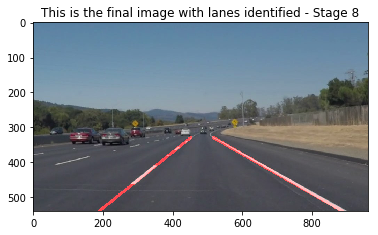

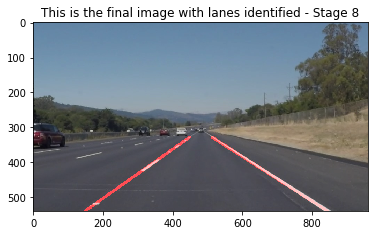

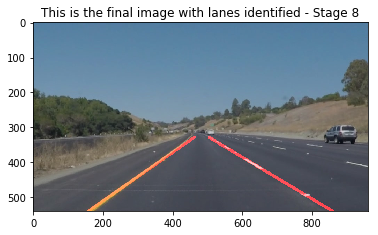

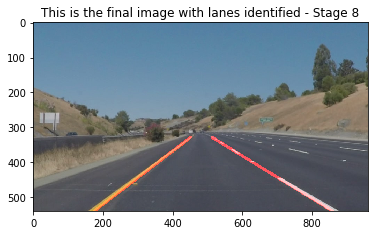

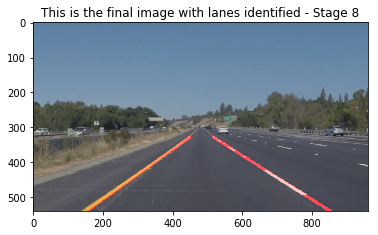

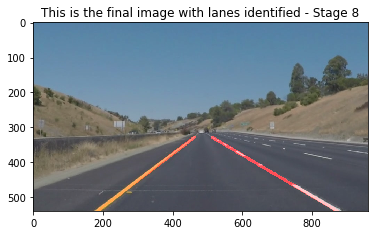

[MoviePy] >>>> Building video test_videos_output\final_challenge.mp4
[MoviePy] Writing video test_videos_output\final_challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:12<00:00, 19.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\final_challenge.mp4 

Wall time: 13.9 s
[MoviePy] >>>> Building video test_videos_output\final_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output\final_solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:05<00:00, 41.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\final_solidWhiteRight.mp4 

Wall time: 5.77 s
[MoviePy] >>>> Building video test_videos_output\final_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output\final_solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:21<00:00, 34.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\final_solidYellowLeft.mp4 

Wall time: 21.8 s


In [3]:
def main():   
    
    obj_lane_detection = CLaneDetection(gaussian_kernel_size = 3,
                                       canny_lower_treshold = 50, canny_upper_treshold = 150, 
                                       hough_rho = 1, hough_theta = np.pi/180, 
                                       hough_threshold = 5, hough_min_line_length = 10, 
                                       hough_max_line_gap = 15, debug_logging = False)
    
    test_images = os.listdir('test_images')
    
    # Loop over the dir containing test images and store the final images
    for image_name in test_images:
        image_path = os.path.join('test_images', image_name)
        original_image = mpimg.imread(image_path)

        final_image = obj_lane_detection.process_image(original_image)
        plt.imshow(final_image)
        plt.title("This is the final image with lanes identified - Stage 8")
        plt.show()
        
        #Save the final image
        output_image_path = os.path.join('test_images_output', 'final_'+ image_name )
        plt.imsave(output_image_path, final_image)

    test_videos = os.listdir('test_videos')
    
    # Loop over the dir containing test videos and store the final videos
    for video_name in test_videos:
        video_path = os.path.join('test_videos', video_name)
        clip = VideoFileClip(video_path)
        final_video_path = os.path.join('test_videos_output', 'final_' + video_name)
        
        video_clip = clip.fl_image(obj_lane_detection.process_image)
        %time video_clip.write_videofile(final_video_path, audio=False)

        HTML("""
            <video width="960" height="540" controls>
            <source src="{0}">
            </video>
            """.format(final_video_path))
        
main()